In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as data

import torchvision.utils as utils
import os
import math

In [2]:
import torch.optim as optm
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import _LRScheduler

from torch.utils.data import DataLoader, Subset, SubsetRandomSampler
from sklearn.model_selection import KFold

In [3]:
from timm.models.layers import trunc_normal_, DropPath
from timm.models.registry import register_model

In [4]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [5]:
# using gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [6]:
n_classes = 4
batch_size = 2

In [7]:
#dataset path
data_path_train = "data/training"
data_path_test = "data/testing"

In [9]:
# data transform, you can add different transform methods and resize image to any size
img_size = 384

transform = transforms.Compose([
                       transforms.Resize((img_size,img_size)),
                       # transforms.ColorJitter(brightness=0.5),
                       # transforms.RandomRotation(degrees=45),
                       transforms.RandomHorizontalFlip(p=0.5),
                       # transforms.RandomVerticalFlip(p=0.5),
                       transforms.ToTensor(),
                       # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                       ])


# build dataset
dataset = datasets.ImageFolder(root=data_path_train,transform=transform)

# spilt your data into train and val
TOTAL_SIZE = len(dataset)
ratio = 0.8
train_len = round(TOTAL_SIZE * ratio)
valid_len = round(TOTAL_SIZE * (1-ratio))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, valid_len])

Kfold = KFold(n_splits=5, shuffle=True, random_state=42)

#build dataloader
for train_idx, valid_idx in Kfold.split(dataset):
    train_data = Subset(dataset, train_idx)
    valid_data = Subset(dataset, valid_idx)
    train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_data_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

#check dataset
print(dataset)
print(dataset.class_to_idx)

Dataset ImageFolder
    Number of datapoints: 1646
    Root location: data/training
    StandardTransform
Transform: Compose(
               Resize(size=(384, 384), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
{'Baked Potato': 0, 'Crispy Chicken': 1, 'Donut': 2, 'Fries': 3}


In [10]:
class_cnt = [0]*4
for i in range(len(dataset)):
    _, label = dataset[i]
    class_cnt[label] += 1

In [11]:
print(class_cnt)

[400, 400, 446, 400]


In [12]:
label_list = ["Baked Potato", "Crispy Chicken", "Donut", "Fries"]

<BarContainer object of 4 artists>

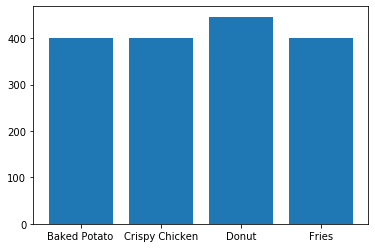

In [13]:
plt.bar(label_list, class_cnt)

## Show Image

In [14]:
examples = next(iter(train_data_loader))

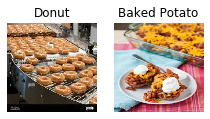

In [15]:
fig = plt.figure(figsize=(15,10))
for idx, img in enumerate(examples[0]):
    ax = fig.add_subplot(5, 8, idx+1)
    ax.imshow(img.permute(1,2,0))
    ax.set_title(f"{label_list[examples[1][idx]]}")
    plt.axis('off')

## Train & Validation

In [16]:
#train function
def train(model, criterion, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    
    # Iterate over data
    for inputs, labels in tqdm(train_data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize
        loss.backward()
        optimizer.step()

        # statistics
        total_loss += loss.item()
        total_correct += torch.sum(preds == labels.data)
        
    avg_loss = total_loss / len(train_data_loader)
    accuracy = total_correct.double() / len(train_dataset) * 100

    print('Train Acc: {:.4f}%, Train Loss: {:.4f}'.format(accuracy, avg_loss))
    return accuracy, avg_loss

#validation function
def valid(model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    
    # Iterate over data
    for inputs, labels in tqdm(val_data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        total_loss += loss.item()
        total_correct += torch.sum(preds == labels.data)
        
    avg_loss = total_loss / len(val_data_loader)
    accuracy = total_correct.double() / len(val_dataset) * 100

    print('Valid Acc: {:.4f}%, Valid Loss: {:.4f}'.format(accuracy, avg_loss))
    return accuracy, avg_loss

In [17]:
from pytorch_pretrained_vit import ViT
model = ViT('B_16_imagenet1k', pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Sequential(
           nn.Dropout(0.5),
           nn.Linear(in_features, n_classes)
           )

Loaded pretrained weights.


In [18]:
print(model)

ViT(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_v): Linear(in_features=768, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (1): Block(
 

In [19]:
print(summary(model))

Layer (type:depth-idx)                                  Param #
├─Conv2d: 1-1                                           590,592
├─PositionalEmbedding1D: 1-2                            443,136
├─Transformer: 1-3                                      --
|    └─ModuleList: 2-1                                  --
|    |    └─Block: 3-1                                  7,087,872
|    |    └─Block: 3-2                                  7,087,872
|    |    └─Block: 3-3                                  7,087,872
|    |    └─Block: 3-4                                  7,087,872
|    |    └─Block: 3-5                                  7,087,872
|    |    └─Block: 3-6                                  7,087,872
|    |    └─Block: 3-7                                  7,087,872
|    |    └─Block: 3-8                                  7,087,872
|    |    └─Block: 3-9                                  7,087,872
|    |    └─Block: 3-10                                 7,087,872
|    |    └─Block: 3-11       

In [20]:
examples = next(iter(train_data_loader))
dummy_input = examples[0]

In [21]:
print(dummy_input.shape)
writer.add_graph(model, dummy_input)

torch.Size([2, 3, 384, 384])


/home/bakerchen/.conda/envs/SNN_v2/lib/python3.6/site-packages/pytorch_pretrained_vit/transformer.py:16: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  shape[shape.index(-1)] = int(x.size(-1) / -np.prod(shape))


## Training Parameters

In [23]:
lr = 0.001
epochs = 20

In [24]:
# optimizer = optm.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.8, weight_decay=1e-5)

In [25]:
criterion = nn.CrossEntropyLoss()

## Train Model

In [26]:
####################  implement your optimizer ###################################
## you can use any training methods if you want (ex:lr decay, weight decay.....)
# start training
model.to(device=device)

acc_best = 0.0


history_train_loss, history_train_acc= [], []
history_val_loss, history_val_acc = [], []

print('--------------start training--------------')
for epoch in range(1, epochs+1):
    # learning rate
    lrs = [l['lr'] for l in optimizer.param_groups]
    print(f'epoch: {epoch}/{epochs}, lr: {lrs[0]:.4f}')
    
    # train & validation
    train_acc, train_loss = train(model, criterion, optimizer)
    val_acc, val_loss = valid(model, criterion)
    
    # history
    history_train_loss.append(train_loss)
    history_train_acc.append(train_acc)
    history_val_loss.append(val_loss)
    history_val_acc.append(val_acc)
    
    # TF board record lr
    writer.add_scalar("LR schedule", lrs[0], epoch)
    
    # TF board record loss
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/valid", val_loss, epoch)
    
    # TF board record acc
    writer.add_scalar("Acc/train", train_acc, epoch)
    writer.add_scalar("Acc/valid", val_acc, epoch)
    
    # TF board record weights
    weight = model.fc[-1].weight
    bias = model.fc[-1].bias
    writer.add_histogram('Weights/Weight', weight, epoch)
    writer.add_histogram('Weights/Bias', bias, epoch)
    
    # TF board record gradient
    grad = weight.grad
    writer.add_histogram("Grad", grad, epoch)
    
    
    if val_acc > acc_best:
        acc_best = val_acc
        print("model saved")
        # save the model
        torch.save(model, "model.pth")
    
    print('-------------------------------------')

--------------start training--------------
epoch: 1/20, lr: 0.0010


100%|██████████| 659/659 [01:12<00:00,  9.06it/s]


Train Acc: 95.2923%, Train Loss: 0.1354


100%|██████████| 165/165 [00:06<00:00, 24.42it/s]


Valid Acc: 96.6565%, Valid Loss: 0.0842
model saved
-------------------------------------
epoch: 2/20, lr: 0.0010


100%|██████████| 659/659 [01:14<00:00,  8.86it/s]


Train Acc: 99.2407%, Train Loss: 0.0246


100%|██████████| 165/165 [00:06<00:00, 24.39it/s]


Valid Acc: 99.6960%, Valid Loss: 0.0166
model saved
-------------------------------------
epoch: 3/20, lr: 0.0010


100%|██████████| 659/659 [01:13<00:00,  8.93it/s]


Train Acc: 99.6203%, Train Loss: 0.0135


100%|██████████| 165/165 [00:06<00:00, 24.90it/s]


Valid Acc: 98.7842%, Valid Loss: 0.0199
-------------------------------------
epoch: 4/20, lr: 0.0010


100%|██████████| 659/659 [01:13<00:00,  8.96it/s]


Train Acc: 100.0000%, Train Loss: 0.0020


100%|██████████| 165/165 [00:06<00:00, 24.87it/s]


Valid Acc: 99.0881%, Valid Loss: 0.0229
-------------------------------------
epoch: 5/20, lr: 0.0010


100%|██████████| 659/659 [01:13<00:00,  8.99it/s]


Train Acc: 100.0000%, Train Loss: 0.0018


100%|██████████| 165/165 [00:06<00:00, 25.00it/s]


Valid Acc: 98.4802%, Valid Loss: 0.0360
-------------------------------------
epoch: 6/20, lr: 0.0010


100%|██████████| 659/659 [01:13<00:00,  8.99it/s]


Train Acc: 100.0000%, Train Loss: 0.0010


100%|██████████| 165/165 [00:06<00:00, 24.49it/s]


Valid Acc: 98.4802%, Valid Loss: 0.0226
-------------------------------------
epoch: 7/20, lr: 0.0010


100%|██████████| 659/659 [01:12<00:00,  9.06it/s]


Train Acc: 100.0000%, Train Loss: 0.0007


100%|██████████| 165/165 [00:06<00:00, 24.40it/s]


Valid Acc: 99.0881%, Valid Loss: 0.0222
-------------------------------------
epoch: 8/20, lr: 0.0010


100%|██████████| 659/659 [01:13<00:00,  9.03it/s]


Train Acc: 100.0000%, Train Loss: 0.0009


100%|██████████| 165/165 [00:06<00:00, 24.50it/s]


Valid Acc: 99.3921%, Valid Loss: 0.0190
-------------------------------------
epoch: 9/20, lr: 0.0010


100%|██████████| 659/659 [01:13<00:00,  9.01it/s]


Train Acc: 100.0000%, Train Loss: 0.0004


100%|██████████| 165/165 [00:06<00:00, 24.38it/s]


Valid Acc: 99.6960%, Valid Loss: 0.0122
-------------------------------------
epoch: 10/20, lr: 0.0010


100%|██████████| 659/659 [01:13<00:00,  9.00it/s]


Train Acc: 100.0000%, Train Loss: 0.0008


100%|██████████| 165/165 [00:06<00:00, 24.89it/s]


Valid Acc: 99.0881%, Valid Loss: 0.0131
-------------------------------------
epoch: 11/20, lr: 0.0010


100%|██████████| 659/659 [01:13<00:00,  8.94it/s]


Train Acc: 100.0000%, Train Loss: 0.0003


100%|██████████| 165/165 [00:06<00:00, 24.89it/s]


Valid Acc: 99.3921%, Valid Loss: 0.0130
-------------------------------------
epoch: 12/20, lr: 0.0010


100%|██████████| 659/659 [01:14<00:00,  8.88it/s]


Train Acc: 100.0000%, Train Loss: 0.0002


100%|██████████| 165/165 [00:06<00:00, 25.03it/s]


Valid Acc: 98.7842%, Valid Loss: 0.0157
-------------------------------------
epoch: 13/20, lr: 0.0010


100%|██████████| 659/659 [01:14<00:00,  8.86it/s]


Train Acc: 100.0000%, Train Loss: 0.0002


100%|██████████| 165/165 [00:06<00:00, 24.88it/s]


Valid Acc: 98.7842%, Valid Loss: 0.0194
-------------------------------------
epoch: 14/20, lr: 0.0010


100%|██████████| 659/659 [01:14<00:00,  8.85it/s]


Train Acc: 100.0000%, Train Loss: 0.0002


100%|██████████| 165/165 [00:06<00:00, 24.83it/s]


Valid Acc: 99.0881%, Valid Loss: 0.0144
-------------------------------------
epoch: 15/20, lr: 0.0010


100%|██████████| 659/659 [01:13<00:00,  8.91it/s]


Train Acc: 100.0000%, Train Loss: 0.0002


100%|██████████| 165/165 [00:06<00:00, 24.87it/s]


Valid Acc: 99.3921%, Valid Loss: 0.0163
-------------------------------------
epoch: 16/20, lr: 0.0010


100%|██████████| 659/659 [01:13<00:00,  9.00it/s]


Train Acc: 100.0000%, Train Loss: 0.0002


100%|██████████| 165/165 [00:06<00:00, 24.83it/s]


Valid Acc: 98.7842%, Valid Loss: 0.0156
-------------------------------------
epoch: 17/20, lr: 0.0010


100%|██████████| 659/659 [01:12<00:00,  9.05it/s]


Train Acc: 100.0000%, Train Loss: 0.0002


100%|██████████| 165/165 [00:06<00:00, 24.76it/s]


Valid Acc: 99.0881%, Valid Loss: 0.0131
-------------------------------------
epoch: 18/20, lr: 0.0010


100%|██████████| 659/659 [01:13<00:00,  9.02it/s]


Train Acc: 100.0000%, Train Loss: 0.0008


100%|██████████| 165/165 [00:06<00:00, 24.92it/s]


Valid Acc: 98.7842%, Valid Loss: 0.0221
-------------------------------------
epoch: 19/20, lr: 0.0010


100%|██████████| 659/659 [01:13<00:00,  8.94it/s]


Train Acc: 100.0000%, Train Loss: 0.0002


100%|██████████| 165/165 [00:06<00:00, 24.81it/s]


Valid Acc: 99.0881%, Valid Loss: 0.0206
-------------------------------------
epoch: 20/20, lr: 0.0010


100%|██████████| 659/659 [01:13<00:00,  8.93it/s]


Train Acc: 100.0000%, Train Loss: 0.0002


100%|██████████| 165/165 [00:06<00:00, 24.48it/s]

Valid Acc: 99.0881%, Valid Loss: 0.0261
-------------------------------------


In [27]:
print(f"Best Validation Acc: {acc_best.cpu():.2f}%")

Best Validation Acc: 99.70%


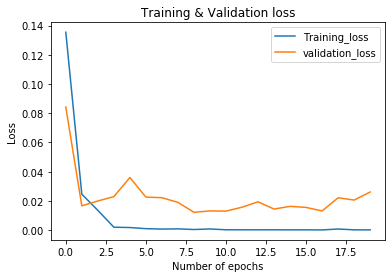

In [28]:
plt.plot(history_train_loss, label='Training_loss')
plt.plot(history_val_loss, label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

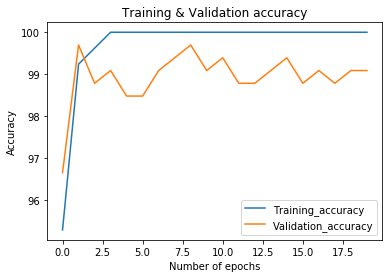

In [29]:
plt.plot(history_train_acc, label='Training_accuracy')
plt.plot(history_val_acc, label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
transform_test = transforms.Compose([transforms.Resize((img_size,img_size)),
                                     transforms.ToTensor()
                                    ])

dataset_test = datasets.ImageFolder(root=data_path_test, transform=transform_test)
dataloader_test  = data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4) 

In [31]:
# load the model so that you don't need to train the model again
test_model = torch.load("model.pth").to(device)

In [32]:
def test(model):
    with torch.no_grad():
        model.eval()
        bs = dataloader_test.batch_size
        result = []
        for i, (data, target) in enumerate(dataloader_test):
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1, keepdim=True)
            
            arr = preds.data.cpu().numpy()
            for j in range(preds.size()[0]):
                file_name = dataset_test.samples[i*bs+j][0].split('/')[-1]
                result.append((file_name,preds[j].cpu().numpy()[0]))
    return result

In [33]:
result = test(test_model)

In [34]:
with open ('ID_result.csv','w') as f:
    f.write('ID,label\n')
    for data in result:
        f.write(data[0]+','+str(data[1])+'\n')